In [29]:
from PIL import Image
import os
import shutil
import numpy as np
# import cv2
import re
import pickle
import random
import time
# from tqdm import tqdm
import pandas as pd 
from glob import glob
from xml.etree.ElementTree import parse
# from pascal_voc_writer import Writer
import matplotlib.pyplot as plt

In [30]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

# ################# DETR FUCNTIONS FOR LOSS######################## 
# import sys
# sys.path.extend(['/tmp/packages/detr/'])

# from models.matcher import HungarianMatcher
# from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [31]:
import sys
sys.path.extend(['./util/'])
from data_parser import *
from image_prepro import *

In [32]:
# !pip3 install torch albumentations
# !pip3 install opencv-python
# !pip3 install torchvision
!pwd

/home/beomgon/Object_Detection/detr


In [33]:
src_path = '/home/beomgon/Object_Detection/Dataset'
df = pd.DataFrame(columns=['label', 'org_label', 'bbox', 'xmin','ymin','xmax','ymax','width','height', 'file_name', 'path'])
# df = pd.DataFrame(columns=['class','bbox', 'path'])
data_list = []
for dir_name in ['SS', 'SS2']:
    dpath = os.path.join(src_path, dir_name)
#     print(dpath)
    dir_lists = os.listdir(dpath) 
#     print(dir_lists)
    
    for dir_list in dir_lists :
        dpath2 = os.path.join(dpath, dir_list)
        xml_list = [os.path.join(dpath2, d) for d in os.listdir(dpath2) if d.endswith(".xml")]
#         print(xml_list)
        for xml_path in xml_list :
            parser = XMLParser(xml_path)
#             if (parser.height, parser.width) not in parser.rejection_size:  
            filename = parser.file_name
            for obj in parser.objects :
#                     obj_class = obj[0]
#                     if obj_class in rej_table :
#                         continue
#                     print(obj)
                img_path = '/'.join((xml_path.split('/')[:-1])) + '/' + filename
#                 img_path = re.sub('xml', 'jpg', xml_path)
# #                     print(img_path)
                obj.append(parser.width)
                obj.append(parser.height)
                obj.append(parser.file_name)
                obj.append(img_path)
                data_list.append(obj)
# #                     print(obj)

        
        
        

In [34]:
# test_path = '/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg'
# test_list = test_path.split('/')
# test_list
# '/'.join(test_list[:-1])

In [35]:
data_list[0]

['Carcinoma',
 'Suamous cell carcinoma',
 [2061, 1051, 2178, 1175],
 2061,
 1051,
 2178,
 1175,
 4032,
 1960,
 '20200623_100015.jpg',
 '/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg']

In [36]:
df = pd.DataFrame(data_list,columns=['label', 'org_label', 'bbox', 'xmin','ymin','xmax','ymax','width','height', 'file_name', 'path'])
df = df[['label', 'org_label', 'width','height', 'bbox', 'xmin','ymin','xmax','ymax', 'file_name', 'path']]
# df = df.reset_index(drop=True)
# df.drop(columns = ['index'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...


In [37]:
print(df.path[0])

/home/beomgon/Object_Detection/Dataset/SS/06/20200623_100015.jpg


In [38]:
set((df[df['label'] == '']).org_label)

{'AGUS',
 'ASC-H',
 'ASCUS-H',
 'ASCUS-RE',
 'ASCUS-Re',
 'ASCUS-SIL',
 'ASCwUS-SIL',
 'Lymphocyte',
 'Lymphocytes',
 'Reactive cell',
 'Reactive change',
 'abnormal',
 'cavity',
 'dog',
 'leukocyte',
 'leukocytes',
 'pulled pork',
 '삭제'}

In [39]:
print(set(df.label))
df.label = df.label.apply(lambda x : np.nan if x == '' else x)
print(set(df.label))
print((len(df)))
df.dropna(subset=['label'], inplace=True)
df.reset_index(drop=True, inplace=True)
print((len(df)))

{'', 'ASCUS', 'LSIL', 'Normal', 'HSIL', 'Carcinoma'}
{nan, 'ASCUS', 'LSIL', 'Normal', 'HSIL', 'Carcinoma'}
106525
101932


In [40]:
print('5가지 class')
print('HSIL', len(df[df['label'] == 'HSIL']))
print('LSIL',len(df[df['label'] == 'LSIL']))
print('ASCUS',len(df[df['label'] == 'ASCUS']))
print('Carcinoma',len(df[df['label'] == 'Carcinoma']))
print('Normal',len(df[df['label'] == 'Normal']))
print('*'*50)
print('3가지 class')
print('High Risk :', len(df[df['label'] == 'HSIL']) + len(df[df['label'] == 'LSIL']) + len(df[df['label'] == 'Carcinoma']))
print('Low Risk :', len(df[df['label'] == 'ASCUS']))
print('Normal :', len(df[df['label'] == 'Normal']))
      

5가지 class
HSIL 40829
LSIL 4234
ASCUS 8407
Carcinoma 21849
Normal 26613
**************************************************
3가지 class
High Risk : 66912
Low Risk : 8407
Normal : 26613


In [41]:
print('전체 label 개수 ', len(df) )
print('전체 file 개수 ',len(df.file_name.unique()))

전체 label 개수  101932
전체 file 개수  18658


In [42]:
len(set(df.file_name))

18658

In [43]:
# (set(df.org_label))

In [44]:
set(df.label)

{'ASCUS', 'Carcinoma', 'HSIL', 'LSIL', 'Normal'}

In [45]:
# dic_df = df[['file_name', 'label']]

# label_dict = df[['file_name', 'label']].to_dict()
# label_dict

In [46]:
# df['label_count'] = 0
file_label_dict = {}
for i in range(len(df)) :
    if df.loc[i,'file_name'] not in file_label_dict.keys() :
        file_label_dict[df.loc[i,'file_name']] = [df.loc[i,'label']]
    else :
        if df.loc[i,'label'] not in file_label_dict[df.loc[i,'file_name']] :
            file_label_dict[df.loc[i,'file_name']].append(df.loc[i,'label'])
    

In [47]:
# file_label_dict

In [48]:
print(len(file_label_dict))
file_label_df = pd.DataFrame(columns=['file_name', 'label'])
for i, n in enumerate(file_label_dict):
#     print(i)
    file_label_df.loc[i, 'file_name'] = n
    file_label_df.loc[i, 'label'] = file_label_dict[n]
    

18658


In [49]:
# file_label_df['label_cnt'] = 0
file_label_df['label_cnt'] = file_label_df.label.apply(lambda x : len(x)) 
# file_label_df[len(file_label_df['label']) != 1]
print('2개 이상 label이 있는 file의 개수 :', len(file_label_df[file_label_df['label_cnt'] != 1]))

2개 이상 label이 있는 file의 개수 : 408


In [50]:
len(file_label_df.loc[1, 'label'])

1

In [51]:
test_df = file_label_df[file_label_df['label_cnt'] != 1]
test_df.head()

,file_name,label,label_cnt
26,20200420_114313.jpg,"[HSIL, LSIL]",2
53,20200623_130314(0).jpg,"[Carcinoma, HSIL]",2
135,20200420_105558.jpg,"[LSIL, HSIL]",2
147,20200623_113957.jpg,"[HSIL, Carcinoma]",2
151,20200623_134942.jpg,"[HSIL, Carcinoma]",2


In [52]:
test_df['isNormal'] = test_df.label.apply(lambda x : 1 if 'Normal' in x else 0)

<ipython-input-52-0cc98d5142f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['isNormal'] = test_df.label.apply(lambda x : 1 if 'Normal' in x else 0)


In [53]:
# cnt = 0
# test_df.reset_index(inplace=True)
# for i in range(len(test_df)) :
#     if 'Normal' in test_df.loc[i, 'label']:
#         cnt += 1
# print(cnt)        

In [54]:
test_df[test_df['isNormal'] == 1]

,file_name,label,label_cnt,isNormal
4571,20191218_132015.jpg,"[LSIL, Normal]",2,1
4595,20191025_131519.jpg,"[Normal, ASCUS]",2,1
4602,20191108_135418.jpg,"[Normal, ASCUS]",2,1
4605,20191025_153348.jpg,"[Normal, ASCUS]",2,1
4665,20191025_153123.jpg,"[Normal, LSIL]",2,1
...,...,...,...,...
17770,20201029_134538(0).jpg,"[Normal, ASCUS]",2,1
17772,20201029_134538.jpg,"[ASCUS, Normal]",2,1
17794,20201029_143345(0).jpg,"[Normal, ASCUS]",2,1
17825,20201029_143345.jpg,"[ASCUS, Normal]",2,1


In [55]:
df.columns

Index(['label', 'org_label', 'width', 'height', 'bbox', 'xmin', 'ymin', 'xmax',
       'ymax', 'file_name', 'path'],
      dtype='object')

In [56]:
# df[['x', 'y', 'w', 'h']] = 0
df['x'] = 0
df['y'] = 0
df['w'] = 0
df['h'] = 0
df.head()
for i in range(len(df)) :
# for i in range(100) :
    df.loc[i, 'x'] = int((df.loc[i, 'xmin'] + df.loc[i, 'xmax'])/2)
    df.loc[i, 'y'] = int((df.loc[i, 'ymin'] + df.loc[i, 'ymax'])/2)
    df.loc[i, 'w'] = int((df.loc[i, 'xmax'] - df.loc[i, 'xmin'])/2)
    df.loc[i, 'h'] = int((df.loc[i, 'ymax'] - df.loc[i, 'ymin'])/2)

In [57]:
df.head()

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
0,Carcinoma,Suamous cell carcinoma,4032,1960,"[2061, 1051, 2178, 1175]",2061,1051,2178,1175,20200623_100015.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2119,1113,58,62
1,HSIL,HSIL,4032,1960,"[1945, 870, 2024, 941]",1945,870,2024,941,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,1984,905,39,35
2,HSIL,HSIL,4032,1960,"[2400, 947, 2484, 1020]",2400,947,2484,1020,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2442,983,42,36
3,HSIL,HSIL,4032,1960,"[2209, 845, 2307, 912]",2209,845,2307,912,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2258,878,49,33
4,HSIL,HSIL,4032,1960,"[2056, 811, 2144, 866]",2056,811,2144,866,20200420_100401.jpg,/home/beomgon/Object_Detection/Dataset/SS/06/2...,2100,838,44,27


In [58]:
df.to_csv('df1.csv', index=None)

In [59]:
# df = pd.read_csv('df1.csv')
# df.head()

In [60]:
image_data = df.groupby('path')
def get_data(img_id):
    if img_id not in image_data.groups:
        return dict(image_id=img_id, label='', boxes=list())
    
    data  = image_data.get_group(img_id)
    label = data.label.values
#     label = np.unique(data.label.values)
#     assert len(label)==1, 'corrupted data: %s image_id has many labels: %s' %(img_id,label)
#     label=label[0]
    
    
    boxes = data[['x','y','w', 'h']].values
    return dict(image_id = img_id, label=label, boxes = boxes)


In [61]:
images = set(list(df['path']))
images = list(images)
image_list = [get_data(img_id) for img_id in images]

In [62]:
image_list[3]

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/03/20200409_104847.jpg',
 'label': array(['HSIL'], dtype=object),
 'boxes': array([[2165,  878,   57,   74]])}

In [77]:
def draw_rect(img_path, bbox_points, image_label=None, color=(0, 255, 0), thickness=5, is_normalized=False, isCenter=False):
    """ Draw rectangle
    Args:
        img: image
        bbox_points: [xmin, ymin, xmax, ymax]
        color: color rgb value
        thickness: line thickness
        is_normalized: Normalized points or not
    Return:
        img
    """
#     print(bbox_points)
    img = cv2.imread(img_path)
    img = cv2.flip(img, 1)
    h, w = img.shape[:2]
    for cls, box in zip(image_label, bbox_points) :   
        
        if cls == 'Carcinoma' or cls == 'LSIL' or cls == 'HSIL' :
            color = (255, 0, 0)
        elif cls == 'ASCUS' :
            color = (0,255,0)
        else :
            color = (0,0,255)
            
        if is_normalized:
            xmin = int(box[0] * w)
            ymin = int(box[1] * h)
            xmax = int(box[2] * w)
            ymax = int(box[3] * h)
        else:
#             xmin = int(box[0])
#             ymin = int(box[1])
#             xmax = int(box[2])
#             ymax = int(box[3])
            if isCenter :
                xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
            else :
                xmin, ymin, xmax, ymax = (box[0]-box[2], box[1]-box[3], box[2]+box[0], box[3]+box[1])
        print(xmin, ymin, xmax, ymax)

#             img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
        img = cv2.rectangle(img, (ymin, xmin), (ymax, xmax), color, thickness)
            
    return img

def draw_marks(img, points_2d, color=(0, 255, 0), thickness=3, is_normalized=True):
    if is_normalized:
        h, w = img.shape[:2]
        for (x, y) in points_2d:
            cv2.circle(img, (int(x * w), int(y * h)), 1, color, thickness, 1)
    
    else:
        for (x, y) in points_2d:
            cv2.circle(img, (int(x), int(y)), 1, color, thickness, 1)

In [78]:
Image_number = 70
image_list[Image_number]

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/04/20200515_101803(0).png',
 'label': array(['HSIL', 'HSIL', 'HSIL', 'HSIL', 'HSIL'], dtype=object),
 'boxes': array([[ 657,  508,   62,   62],
        [1315,  859,   55,   63],
        [ 616, 1170,   56,   76],
        [1099,  901,   70,   60],
        [ 968,  604,   58,   64]])}

In [79]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# path1 = image_list[Image_number]['image_id']
# # img = cv2.imread(path1)
# bbox_points = [[1000, 900, 100, 50], [1500, 1400, 100, 50], [1500, 2000, 100, 50], [1558,716, 43, 7], [1623, 1063, 61, 70]]
# img = draw_rect(image_list[Image_number]['image_id'], bbox_points)
# plt.figure(figsize=(20, 20))
# plt.imshow(img)

In [80]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# Image_number = 73
# image_list[Image_number]
# img = draw_rect(image_list[Image_number]['image_id'], image_list[Image_number]['boxes'], image_list[Image_number]['label'])

# plt.figure(figsize=(20, 20))
# plt.imshow(img)
# # Image.open(img)


In [81]:
df[df['file_name'] == '20200903_093101(0).jpg']

,label,org_label,width,height,bbox,xmin,ymin,xmax,ymax,file_name,path,x,y,w,h
101137,ASCUS,ASCUS,4000,1800,"[2515, 639, 2601, 794]",2515,639,2601,794,20200903_093101(0).jpg,/home/beomgon/Object_Detection/Dataset/SS2/02(...,2558,716,43,77
101138,ASCUS,ASCUS,4000,1800,"[2362, 993, 2484, 1134]",2362,993,2484,1134,20200903_093101(0).jpg,/home/beomgon/Object_Detection/Dataset/SS2/02(...,2423,1063,61,70


In [82]:
Image_number = 6000
image_list[Image_number]

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/05/20200416_135343(0).jpg',
 'label': array(['HSIL'], dtype=object),
 'boxes': array([[2100, 1060,  115,  115]])}

In [83]:
# # !cp /home/beomgon/Object_Detection/Dataset/SS2/'02(200901-04)'/20200903_105054.jpg ./test1.jpg

# from PIL import Image
# im = Image.open('test1.jpg')
# im.show()

In [84]:
# import cv2
# img = cv2.imread('test1.jpg')
# # plt.figure(figsize=(20, 20))
# # plt.imshow(img)
# img = cv2.flip(img, 1)
# cv2.imwrite('test2.jpg', img)
# # im = Image.open('test2.jpg')
# # im.show()

{'image_id': '/home/beomgon/Object_Detection/Dataset/SS/01/20200218_112049(0).jpg', 'label': array(['LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL',
       'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL', 'LSIL',
       'LSIL', 'LSIL', 'LSIL', 'LSIL'], dtype=object), 'boxes': array([[1892,  668,   46,   60],
       [2121,  743,   53,   43],
       [2146,  411,   58,   44],
       [2282,  955,   50,   55],
       [2305, 1382,   40,   51],
       [2535, 1121,   39,   43],
       [1786, 1293,   46,   37],
       [1422,  440,   46,   45],
       [2036,  457,   35,   40],
       [1911,  397,   43,   39],
       [2414,  772,   49,   47],
       [1835,  954,   47,   32],
       [1883, 1007,   37,   32],
       [1966,  921,   37,   35],
       [1762,  744,   41,   36],
       [1579,  917,   50,   36],
       [2434,  258,   33,   47],
       [1751, 1146,   44,   49],
       [2391, 1201,   37,   45],
       [1884,  237,   58,   45]])}
1846 608 1938 728
2068 700 2174 786
208

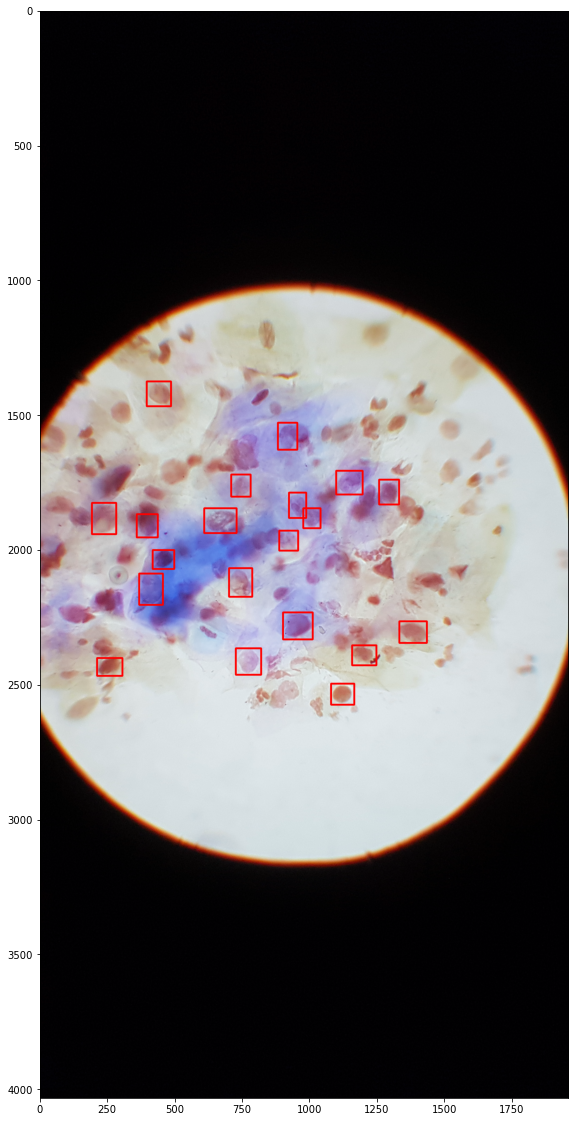

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

Image_number = 3000
image_list[Image_number]
print(image_list[Image_number])
img = draw_rect(image_list[Image_number]['image_id'], image_list[Image_number]['boxes'], image_list[Image_number]['label'])
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [ ]:

# img = cv2.imread('/home/beomgon/Object_Detection/Dataset/SS/04/20200515_134716.jpg')
# print(type(img))
# image_list[16000]

In [ ]:
# img = cv2.imread('/home/beomgon/Object_Detection/Dataset/SS2/02(200901-04)/20200903_093101(0).jpg')
# print(img.shape)
# img = crop_image(img)
# print(img.shape)

In [ ]:
# df.head()

In [ ]:
new_df = df.copy()

In [ ]:
new_df.head()

In [ ]:
new_df = new_df[['label', 'width', 'height', 'bbox', 'path']]
new_df.head()

In [ ]:
new_df.head()

In [ ]:
# new_df['new_bbox'] = []
new_bbox_list = []
new_width = []
new_height = []
for i in range(len(new_df)) :
    h, w = new_df.loc[i, 'width'], new_df.loc[i, 'height']
    if (h, w) == (4032, 1960):
        h_margin = 1341
        w_margin = 305
    
    elif (h, w) == (4000, 1800):
        h_margin = 1325
        w_margin = 225

    elif (h, w) == (1800, 4000):
        h_margin = 225
        w_margin = 1325
    
    else:
        h_margin = 0
        w_margin = 0
    
    xmin, ymin, xmax, ymax = new_df.loc[i, 'bbox']
    xmin -= h_margin
    ymin -= w_margin
    xmax -= h_margin
    ymax -= w_margin
    new_bbox_point = [xmin, ymin, xmax, ymax]  
#     print(new_df.loc[i, 'new_bbox'])
#     print(new_bbox_point)
    new_bbox_list.append(new_bbox_point)
    new_width.append(w)
    new_height.append(h)
new_df['new_bbox'] = new_bbox_list
# new_df['new_width'] = new_width
# new_df['new_height'] = new_height
    

In [ ]:
# new_df.drop(columns=['new_bbox'],inplace=True)
# new_df.drop(columns=['new_width', 'new_height'],inplace=True)
# new_df.to_csv('new_df.csv', index=None)

In [ ]:
# img = cv2.imread('/home/beomgon/Object_Detection/Dataset/SS2/02(200901-04)/20200903_093101(0).jpg')
# print(img.shape)
# img = crop_image(img)
# print(img.shape)

# cv2.imwrite('./test.jpg', img)




In [ ]:
# import os
# def mkdir_p(directory):
#     """Like mkdir -p ."""
#     if not directory:
#         return
#     if directory.endswith("/"):
#         mkdir_p(directory[:-1])
#         return
#     if os.path.isdir(directory):
#         return
#     print(os.path.dirname(directory))

#     mkdir_p(os.path.dirname(directory))
#     #os.path.dirname(directory)를 하면 상위 폴더 경로로 올라감
#     print("Start")
#     print(directory)
#     os.mkdir(directory)

In [ ]:
# make folder for croped file
# !find Dataset/ -type d -exec mkdir -p New/{} \;
# !mv New Dataset/

In [ ]:
!pwd

In [ ]:
new_df['new_path'] = ''
cnt = 0
for i in range(len(new_df)) :
    path = new_df.loc[i, 'path']

#     path = re.sub('.jpg', '_new.jpg', path)
#     path = re.sub('.png', '_new.png', path)
    newpath = re.sub('Dataset/SS', 'Dataset/New/SS',path)
    new_df.loc[i, 'new_path'] = newpath
    if not os.path.isfile(newpath) :
        
    #     folder = '/' + '/'.join(path.split('/')[1:7])
    #     print(folder)
    #     print(path)
    #     if not os.path.isdir(folder):  
    #     mkdir_p(folder)
        img = cv2.imread(path)
        print(path)
        print(type(img))
        img = cv2.flip(img, 1)
        img = crop_image(img)

        cv2.imwrite(newpath, img)
        cnt += 1
        if cnt > 20 :
            adfsdf
    
                     

In [ ]:
# new_df.to_csv('new_df.csv', index=None)
new_df.to_csv('new_df.csv', index=None)
new_df.head(10)

In [ ]:
image_list[Image_number]['image_id']

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

path1 = '/home/beomgon/Object_Detection/Dataset/New/SS/06/20200420_100401.jpg'
# path1 = '20200623_100015.jpg'
# img = cv2.imread(path1)
# bbox_points = [[720, 746, 58,62]]
bbox_points = new_df.new_bbox[1:10]
img = draw_rect(path1, list(bbox_points), ['HSIL']*9, isCenter=True)
plt.figure(figsize=(20, 20))
plt.imshow(img)

In [ ]:
# mkdir_p('/home/beomgon/Object_Detection/Dataset/New')

In [ ]:
new_df.head()

In [ ]:
['HSIL']*7

In [ ]:
list(bbox_points)